In [ ]:
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pathlib
import textwrap
import numpy as np

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
# Used to securely store your API key
from google.colab import userdata

In [ ]:
class GeminiPro:
    def __init__(self, role):
        self.role = role
        GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
        genai.configure(api_key=GOOGLE_API_KEY)
        self.model = genai.GenerativeModel('gemini-pro')

    def generate_answer(self, question):
        # Generate answer using Gemini Pro model
        response = self.model.generate_content(question)
        answer = ""
        for part in response.parts:
            answer += part.text + "\n"
        return answer

banker = "You are a banker assistant. You help a banker to interprete data, model, insights generated AI/machine learning when making decisions on loan origination."
gemini_pro = GeminiPro(banker)

### Create a list of potential questions

In [ ]:
QUESTION1 = {
    "title": "Deliquency",
    "content": "How does annual income affect the delinquency?"}
QUESTION2 = {
    "title": "Lending Trends",
    "content": "What are the trends of lending for different lending purposes (home improvement, credit card debt consolidation, small business, etc), e.g. default rate, lending size, borrower democrafic?"}
QUESTION3 = {
    "title": "Risk Adjusted Return",
    "content": "If I am a lender, what loans provide the best risk adjusted return?"}

documents = [QUESTION1, QUESTION2, QUESTION3]

df = pd.DataFrame(documents)
df.columns = ['Title', 'Text']

# Get the embeddings of each text and add to an embeddings column in the dataframe
def embed_fn(title, text):
  return genai.embed_content(model='models/embedding-001',
                             content=text,
                             task_type="retrieval_document",
                             title=title)["embedding"]

df['Embeddings'] = df.apply(lambda row: embed_fn(row['Title'], row['Text']), axis=1)

In [ ]:
def find_best_passage(query, dataframe):
  """
  Compute the distances between the query and each document in the dataframe
  using the dot product.
  """
  query_embedding = genai.embed_content(model='models/embedding-001',
                                        content=query,
                                        task_type="retrieval_query")
  dot_products = np.dot(np.stack(dataframe['Embeddings']), query_embedding["embedding"])
  idx = np.argmax(dot_products)
  print(f"Banker's Most Consistent Answer (index {idx+1}):")
  return dataframe.iloc[idx]['Text']

### Based on the user query, extract "question" that is the most consistent with what the user asks

##### An example of user query. Note that this example purposefully phrases the original question "What are the lending trends for different purposes over the years? Include default rates, lending size, and borrowers' demographics" differently to see if the LLM can help us choose the most relevant question that it knows to solve.

In [ ]:
query = "How has the average loan amount, default rate, income and employment length changed over the years for different loan purposes?"
question = find_best_passage(query, df)
question

Banker's Most Consistent Answer (index 2):


'What are the trends of lending for different lending purposes (home improvement, credit card debt consolidation, small business, etc), e.g. default rate, lending size, borrower democrafic?'

## Step 1: User Query Parsing

In [ ]:
prompt = f"""Can you parse the question {question} to determine the variables of interest.
Once you determine the variables of interest, examine the following data schema and dictionary to give me variables from the data schema that match the determined variables of interest.

Data Schema:
sub_grade: The sub-grade assigned by Lending Club based on the borrower's creditworthiness. \
grade: The grade assigned by Lending Club based on the borrower's creditworthiness. \
loan_status: The status of the loan, whether it's fully paid, charged off, or other. \
purpose: The purpose of the loan, such as debt consolidation, home improvement, etc. \
issue_y: The year in which the loan was issued. \
term_36m: Binary indicator (0 or 1) indicating whether the loan term is 36 months. \
term_60m: Binary indicator (0 or 1) indicating whether the loan term is 60 months. \
revol_util_n: The revolving utilization rate, representing the amount of credit used relative to the total credit available. \
int_rate_n: The interest rate on the loan. \
installment_n: The monthly installment payment amount. \
tot_hi_cred_lim_n: Total high credit/credit limit. \
emp_length_n: Length of employment in years. \
dti_n: Debt-to-income ratio. \
avg_cur_bal_n: Average current balance. \
all_util_n: Credit utilization rate on all accounts. \
acc_open_past_24mths_n: Number of accounts opened in the past 24 months. \
annual_inc_n: Annual income. \
loan_amnt_n: Loan amount.

Data Dictionary:

"sub_grade": "string", \
"grade": "string",\
"loan_status": "string",\
"purpose": "string",\
"issue_y": "integer",\
"term_36m": "integer (0 or 1)",\
"term_60m": "integer (0 or 1)",\
"revol_util_n": "float",\
"int_rate_n": "float",\
"installment_n": "float",\
"tot_hi_cred_lim_n": "float",\
"emp_length_n": "float",\
"dti_n": "float",\
"avg_cur_bal_n": "float",\
"all_util_n": "float",\
"acc_open_past_24mths_n": "integer",\
"annual_inc_n": "float",\
"loan_amnt_n": "float"\
"""
# Generate answer using Gemini Pro
answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(answer)

Banker's Answer:


> **Variables of interest:**
> 
> * Default rates
> * Lending size
> * Borrowers' demographics
> 
> **Variables from the data schema:**
> 
> * **Default rates:** loan_status (fully paid, charged off, or other)
> * **Lending size:** loan_amnt_n
> * **Borrowers' demographics:** 
>     * issue_y (year of loan issue)
>     * purpose (purpose of the loan)
>     * revol_util_n (revolving utilization rate)
>     * int_rate_n (interest rate on the loan)
>     * installment_n (monthly installment payment amount)
>     * tot_hi_cred_lim_n (total high credit/credit limit)
>     * emp_length_n (length of employment in years)
>     * dti_n (debt-to-income ratio)
>     * avg_cur_bal_n (average current balance)
>     * all_util_n (credit utilization rate on all accounts)
>     * acc_open_past_24mths_n (number of accounts opened in the past 24 months)
>     * annual_inc_n (annual income)


## Step 2: Trend Analysis

In [ ]:
prompt = f"""Given the following data schema and dictionary along with the parsed variables that match the data scheme, can you generate a Python code to answer this question: {question}?

Data Schema:
sub_grade: The sub-grade assigned by Lending Club based on the borrower's creditworthiness. \
grade: The grade assigned by Lending Club based on the borrower's creditworthiness. \
loan_status: The status of the loan, whether it's fully paid, charged off, or other. \
purpose: The purpose of the loan, such as debt consolidation, home improvement, etc. \
issue_y: The year in which the loan was issued. \
term_36m: Binary indicator (0 or 1) indicating whether the loan term is 36 months. \
term_60m: Binary indicator (0 or 1) indicating whether the loan term is 60 months. \
revol_util_n: The revolving utilization rate, representing the amount of credit used relative to the total credit available. \
int_rate_n: The interest rate on the loan. \
installment_n: The monthly installment payment amount. \
tot_hi_cred_lim_n: Total high credit/credit limit. \
emp_length_n: Length of employment in years. \
dti_n: Debt-to-income ratio. \
avg_cur_bal_n: Average current balance. \
all_util_n: Credit utilization rate on all accounts. \
acc_open_past_24mths_n: Number of accounts opened in the past 24 months. \
annual_inc_n: Annual income. \
loan_amnt_n: Loan amount.

Data Dictionary:

"sub_grade": "string", \
"grade": "string",\
"loan_status": "string",\
"purpose": "string",\
"issue_y": "integer",\
"term_36m": "integer (0 or 1)",\
"term_60m": "integer (0 or 1)",\
"revol_util_n": "float",\
"int_rate_n": "float",\
"installment_n": "float",\
"tot_hi_cred_lim_n": "float",\
"emp_length_n": "float",\
"dti_n": "float",\
"avg_cur_bal_n": "float",\
"all_util_n": "float",\
"acc_open_past_24mths_n": "integer",\
"annual_inc_n": "float",\
"loan_amnt_n": "float"\

Parsed Variables:
- Default rates: loan_status (fully paid, charged off, or other)
- Lending size: loan_amnt_n
- Borrowers' demographics:
  issue_y (year of loan issue)
  purpose (purpose of the loan)
  revol_util_n (revolving utilization rate)
  int_rate_n (interest rate on the loan)
  installment_n (monthly installment payment amount)
  tot_hi_cred_lim_n (total high credit/credit limit)
  emp_length_n (length of employment in years)
  dti_n (debt-to-income ratio)
  avg_cur_bal_n (average current balance)
  all_util_n (credit utilization rate on all accounts)
  acc_open_past_24mths_n (number of accounts opened in the past 24 months)
  annual_inc_n (annual income)

The output should be a set of dataframes and charts. You can rescale certain variables to make the charts look more beautiful."""
# Generate answer using Gemini Pro
answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(answer)

Banker's Answer:


> ```python
> import pandas as pd
> import matplotlib.pyplot as plt
> import seaborn as sns
> 
> # Load the data
> data = pd.read_csv('lending_club_data.csv')
> 
> # Create a function to calculate default rates
> def calculate_default_rates(data):
>   """Calculates the default rates for different purposes over the years.
> 
>   Args:
>     data: A pandas DataFrame with the lending data.
> 
>   Returns:
>     A pandas DataFrame with the default rates for different purposes over the years.
>   """
> 
>   # Group the data by purpose and issue year
>   data = data.groupby(['purpose', 'issue_y'])
> 
>   # Calculate the default rate for each group
>   data = data.apply(lambda x: x['loan_status'].value_counts()['Charged Off'] / x['loan_status'].count())
> 
>   # Reset the index
>   data = data.reset_index()
> 
>   return data
> 
> # Create a function to calculate lending size
> def calculate_lending_size(data):
>   """Calculates the lending size for different purposes over the years.
> 
>   Args:
>     data: A pandas DataFrame with the lending data.
> 
>   Returns:
>     A pandas DataFrame with the lending size for different purposes over the years.
>   """
> 
>   # Group the data by purpose and issue year
>   data = data.groupby(['purpose', 'issue_y'])
> 
>   # Calculate the lending size for each group
>   data = data.apply(lambda x: x['loan_amnt_n'].mean())
> 
>   # Reset the index
>   data = data.reset_index()
> 
>   return data
> 
> # Create a function to calculate borrowers' demographics
> def calculate_borrowers_demographics(data):
>   """Calculates the borrowers' demographics for different purposes over the years.
> 
>   Args:
>     data: A pandas DataFrame with the lending data.
> 
>   Returns:
>     A pandas DataFrame with the borrowers' demographics for different purposes over the years.
>   """
> 
>   # Group the data by purpose and issue year
>   data = data.groupby(['purpose', 'issue_y'])
> 
>   # Calculate the borrowers' demographics for each group
>   data = data.apply(lambda x: x[['revol_util_n', 'int_rate_n', 'installment_n', 'tot_hi_cred_lim_n', 'emp_length_n', 'dti_n', 'avg_cur_bal_n', 'all_util_n', 'acc_open_past_24mths_n', 'annual_inc_n']].mean())
> 
>   # Reset the index
>   data = data.reset_index()
> 
>   return data
> 
> # Calculate the default rates
> default_rates = calculate_default_rates(data)
> 
> # Calculate the lending size
> lending_size = calculate_lending_size(data)
> 
> # Calculate the borrowers' demographics
> borrowers_demographics = calculate_borrowers_demographics(data)
> 
> # Plot the default rates
> plt.figure(figsize=(10, 6))
> sns.lineplot(data=default_rates, x='issue_y', y='loan_status', hue='purpose')
> plt.title('Default Rates for Different Purposes Over the Years')
> plt.xlabel('Year')
> plt.ylabel('Default Rate')
> plt.show()
> 
> # Plot the lending size
> plt.figure(figsize=(10, 6))
> sns.lineplot(data=lending_size, x='issue_y', y='loan_amnt_n', hue='purpose')
> plt.title('Lending Size for Different Purposes Over the Years')
> plt.xlabel('Year')
> plt.ylabel('Loan Amount')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='revol_util_n', hue='issue_y')
> plt.title('Revolving Utilization Rate for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Revolving Utilization Rate')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='int_rate_n', hue='issue_y')
> plt.title('Interest Rate for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Interest Rate')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='installment_n', hue='issue_y')
> plt.title('Installment Amount for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Installment Amount')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='tot_hi_cred_lim_n', hue='issue_y')
> plt.title('Total High Credit Limit for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Total High Credit Limit')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='emp_length_n', hue='issue_y')
> plt.title('Employment Length for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Employment Length')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='dti_n', hue='issue_y')
> plt.title('Debt-to-Income Ratio for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Debt-to-Income Ratio')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='avg_cur_bal_n', hue='issue_y')
> plt.title('Average Current Balance for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Average Current Balance')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='all_util_n', hue='issue_y')
> plt.title('Credit Utilization Rate for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Credit Utilization Rate')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='acc_open_past_24mths_n', hue='issue_y')
> plt.title('Number of Accounts Opened in the Past 24 Months for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Number of Accounts Opened in the Past 24 Months')
> plt.show()
> 
> # Plot the borrowers' demographics
> plt.figure(figsize=(10, 6))
> sns.boxplot(data=borrowers_demographics, x='purpose', y='annual_inc_n', hue='issue_y')
> plt.title('Annual Income for Different Purposes Over the Years')
> plt.xlabel('Purpose')
> plt.ylabel('Annual Income')
> plt.show()
> ```


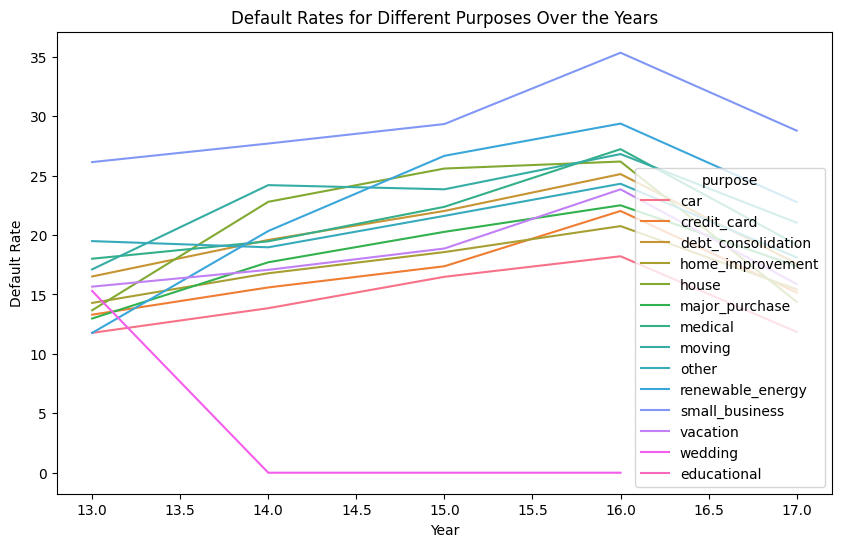

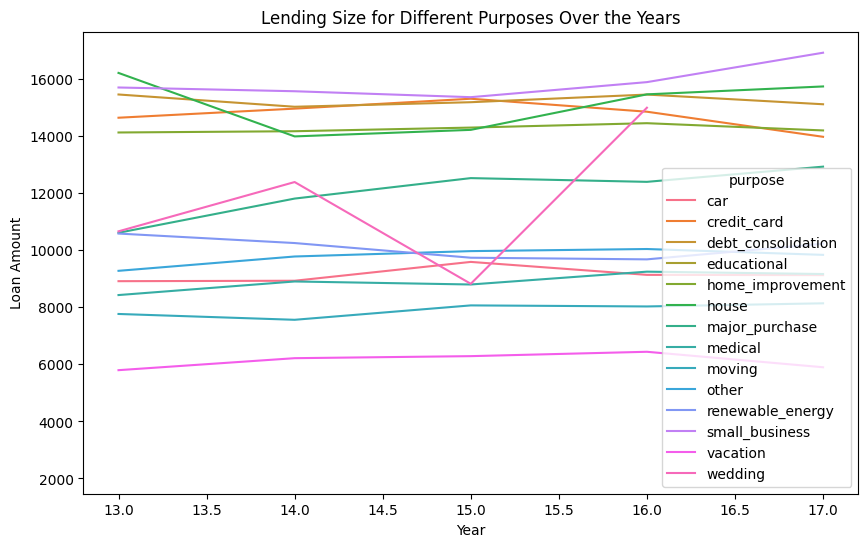

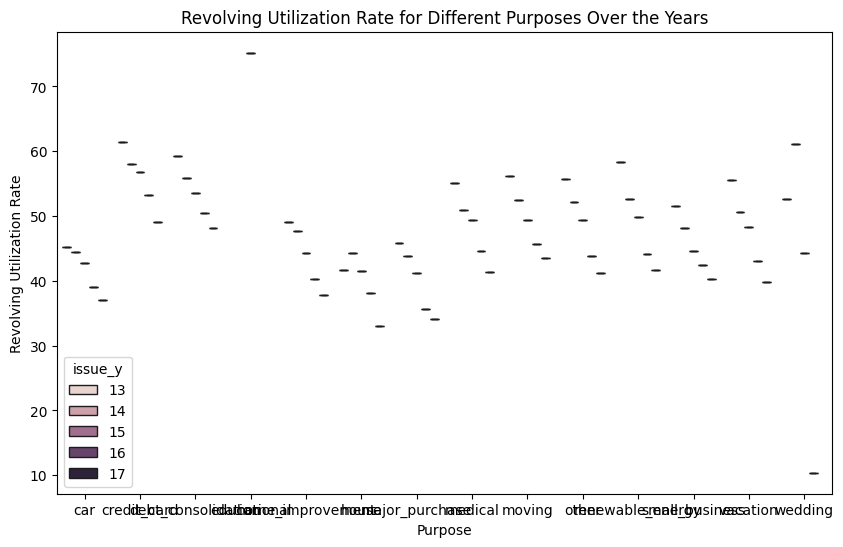

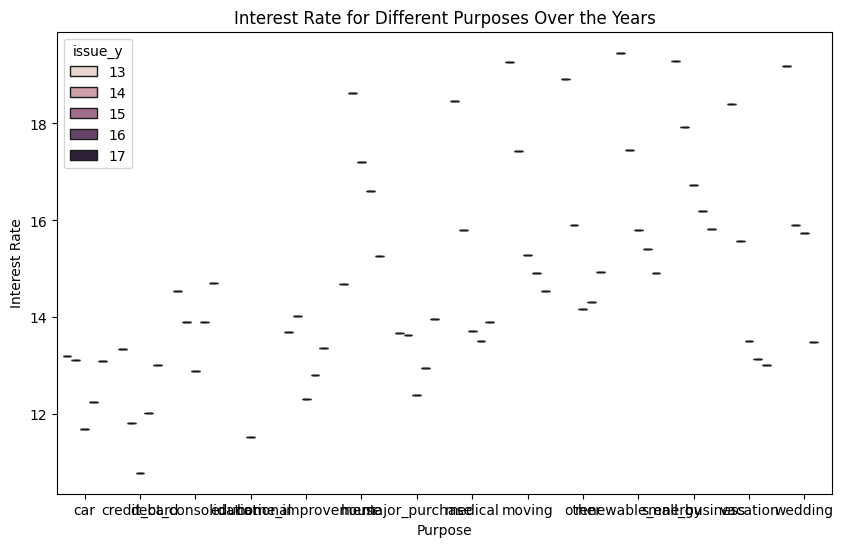

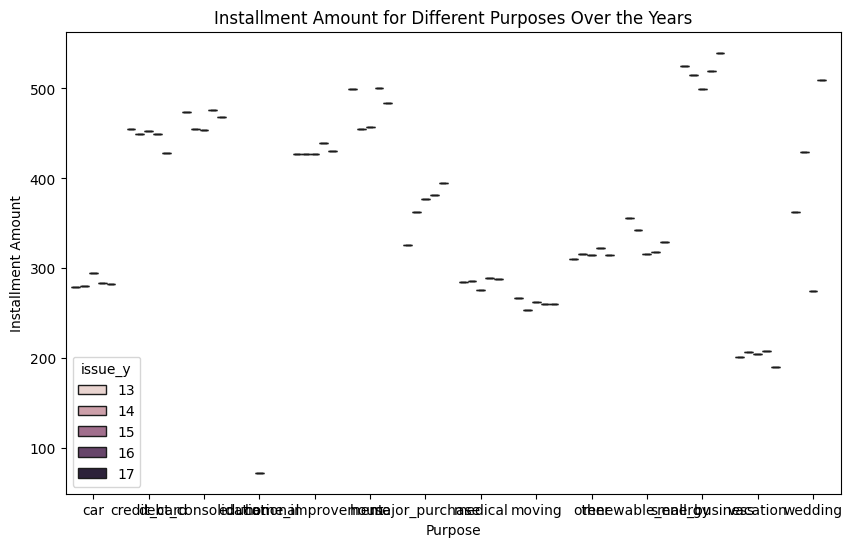

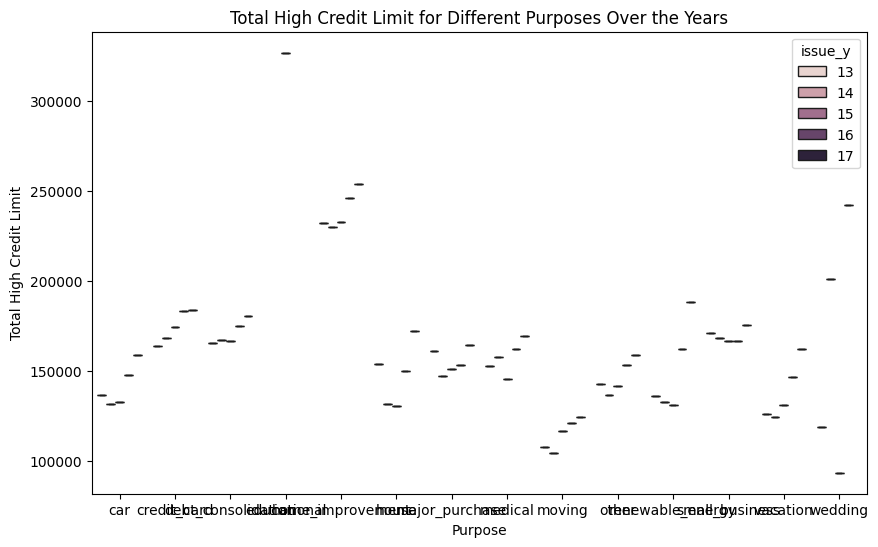

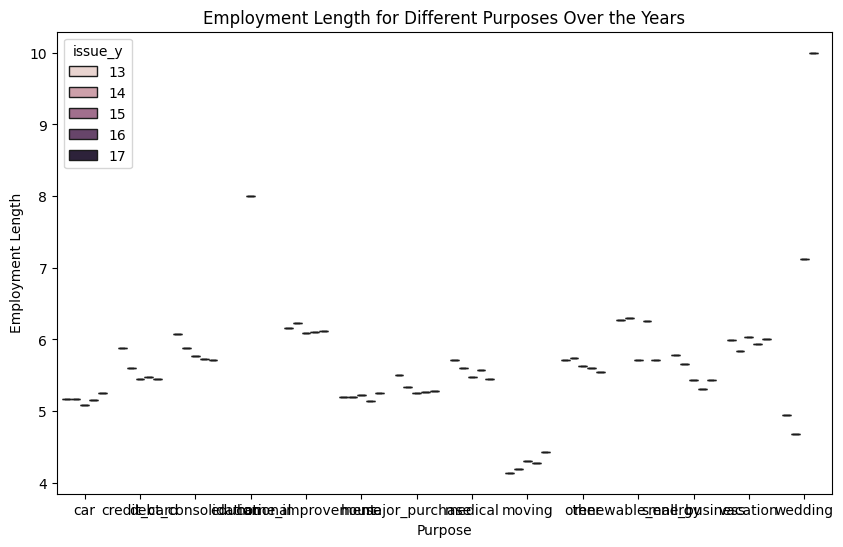

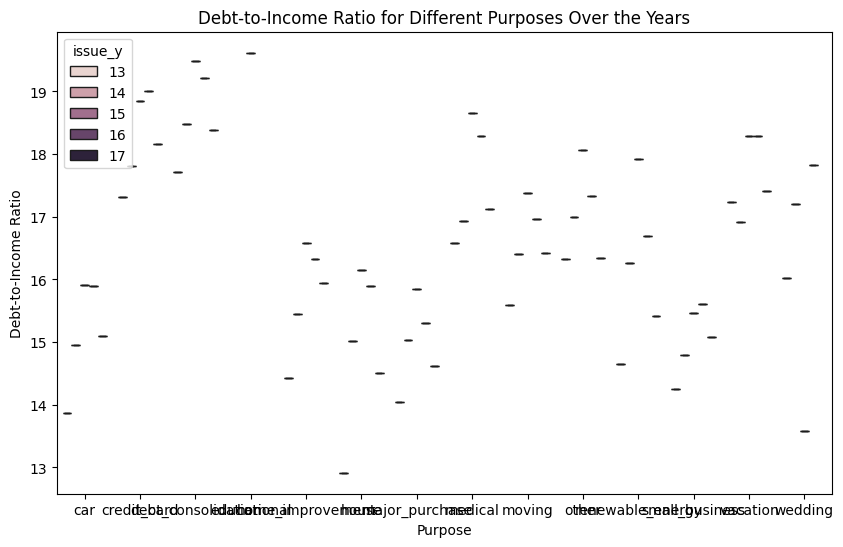

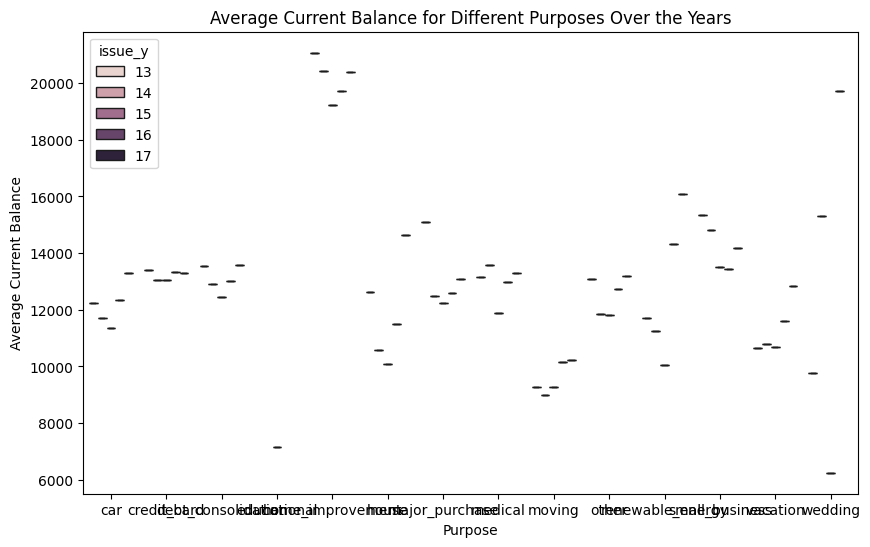

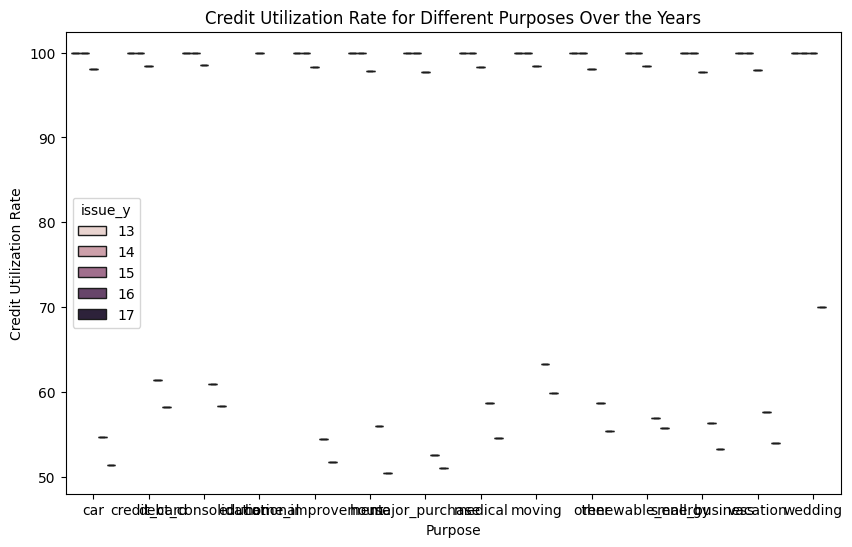

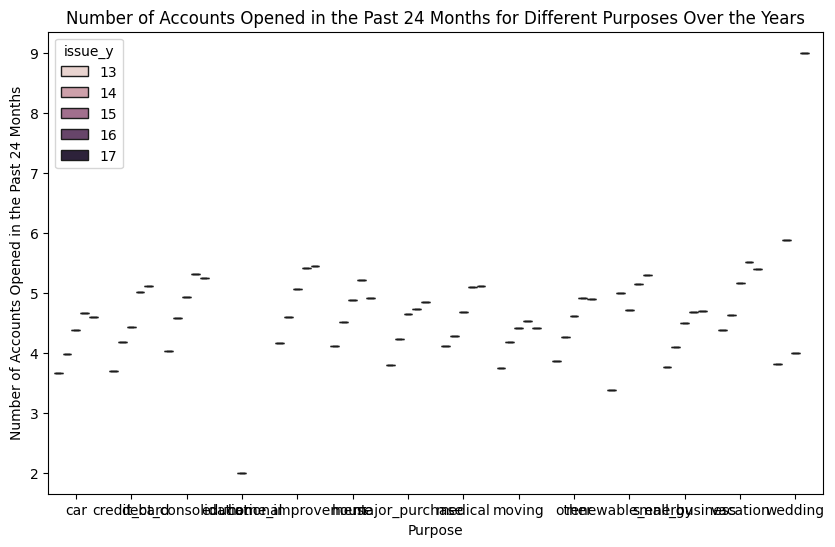

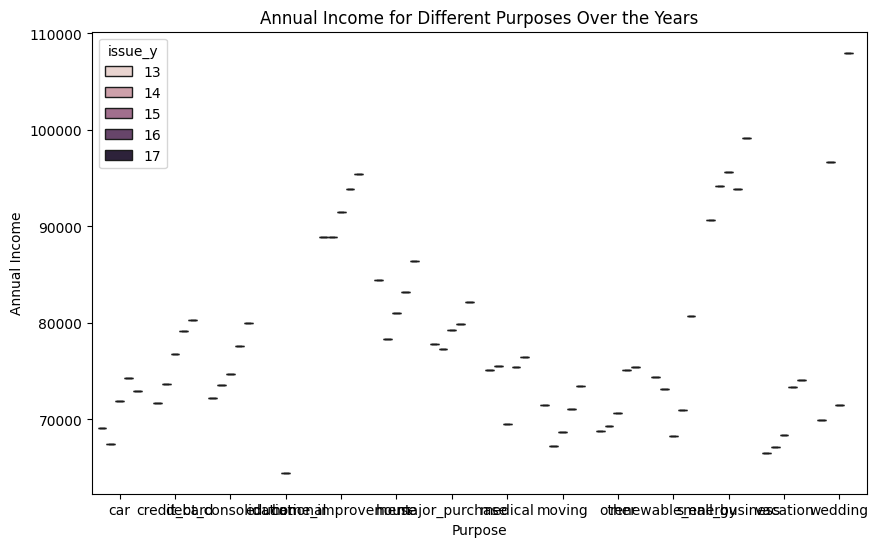

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('lending_club_2013_2017_all_purposes.csv')

# Create a function to calculate default rates
def calculate_default_rates(data):
  """Calculates the default rates for different purposes over the years.

  Args:
    data: A pandas DataFrame with the lending data.

  Returns:
    A pandas DataFrame with the default rates for different purposes over the years.
  """

  # Group the data by purpose and issue year
  data = data.groupby(['issue_y', 'purpose'])['loan_status'].apply(lambda x: (x == 'Charged Off').mean() * 100)

  # Reset the index
  data = data.reset_index()

  return data

# Create a function to calculate lending size
def calculate_lending_size(data):
  """Calculates the lending size for different purposes over the years.

  Args:
    data: A pandas DataFrame with the lending data.

  Returns:
    A pandas DataFrame with the lending size for different purposes over the years.
  """

  # Group the data by purpose and issue year
  data = data.groupby(['purpose', 'issue_y'])

  # Calculate the lending size for each group
  data = data.apply(lambda x: x['loan_amnt_n'].mean())

  # Reset the index
  data = data.reset_index()

  data.columns= ['purpose','issue_y','loan_amnt_n']

  return data

# Create a function to calculate borrowers' demographics
def calculate_borrowers_demographics(data):
  """Calculates the borrowers' demographics for different purposes over the years.

  Args:
    data: A pandas DataFrame with the lending data.

  Returns:
    A pandas DataFrame with the borrowers' demographics for different purposes over the years.
  """

  # Group the data by purpose and issue year
  data = data.groupby(['purpose', 'issue_y'])

  # Calculate the borrowers' demographics for each group
  data = data.apply(lambda x: x[['revol_util_n', 'int_rate_n', 'installment_n', 'tot_hi_cred_lim_n', 'emp_length_n', 'dti_n', 'avg_cur_bal_n', 'all_util_n', 'acc_open_past_24mths_n', 'annual_inc_n']].mean())

  # Reset the index
  data = data.reset_index()

  return data

# Calculate the default rates
default_rates = calculate_default_rates(data)

# Calculate the lending size
lending_size = calculate_lending_size(data)

# Calculate the borrowers' demographics
borrowers_demographics = calculate_borrowers_demographics(data)

# Plot the default rates
plt.figure(figsize=(10, 6))
sns.lineplot(data=default_rates, x='issue_y', y='loan_status', hue='purpose')
plt.title('Default Rates for Different Purposes Over the Years')
plt.xlabel('Year')
plt.ylabel('Default Rate')
plt.show()

# Plot the lending size
plt.figure(figsize=(10, 6))
sns.lineplot(data=lending_size, x='issue_y', y='loan_amnt_n', hue='purpose')
plt.title('Lending Size for Different Purposes Over the Years')
plt.xlabel('Year')
plt.ylabel('Loan Amount')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='revol_util_n', hue='issue_y')
plt.title('Revolving Utilization Rate for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Revolving Utilization Rate')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='int_rate_n', hue='issue_y')
plt.title('Interest Rate for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Interest Rate')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='installment_n', hue='issue_y')
plt.title('Installment Amount for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Installment Amount')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='tot_hi_cred_lim_n', hue='issue_y')
plt.title('Total High Credit Limit for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Total High Credit Limit')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='emp_length_n', hue='issue_y')
plt.title('Employment Length for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Employment Length')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='dti_n', hue='issue_y')
plt.title('Debt-to-Income Ratio for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Debt-to-Income Ratio')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='avg_cur_bal_n', hue='issue_y')
plt.title('Average Current Balance for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Average Current Balance')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='all_util_n', hue='issue_y')
plt.title('Credit Utilization Rate for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Credit Utilization Rate')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='acc_open_past_24mths_n', hue='issue_y')
plt.title('Number of Accounts Opened in the Past 24 Months for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Number of Accounts Opened in the Past 24 Months')
plt.show()

# Plot the borrowers' demographics
plt.figure(figsize=(10, 6))
sns.boxplot(data=borrowers_demographics, x='purpose', y='annual_inc_n', hue='issue_y')
plt.title('Annual Income for Different Purposes Over the Years')
plt.xlabel('Purpose')
plt.ylabel('Annual Income')
plt.show()

## Step 3: Data Extraction

In [ ]:
borrowers_demographics

,purpose,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,emp_length_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n
0,car,13,45.145837,13.198536,279.474746,136600.384689,5.169856,13.871426,12227.603828,100.000000,3.663158,69096.180421
1,car,14,44.469737,13.115132,279.901407,131756.291190,5.173341,14.948810,11719.780892,100.000000,3.976545,67451.913896
2,car,15,42.659919,11.699939,294.832055,132685.841909,5.080399,15.906256,11355.022004,98.020650,4.372038,71920.942390
3,car,16,39.052552,12.240607,283.444157,147754.545244,5.153906,15.886288,12340.916087,54.704176,4.654292,74255.350162
4,car,17,36.965526,13.098942,282.402218,158873.147022,5.246831,15.092611,13284.496831,51.398606,4.585551,73000.467560
...,...,...,...,...,...,...,...,...,...,...,...,...
60,vacation,17,39.751317,13.009759,190.601023,162104.544018,6.010534,17.415485,12841.629044,54.011287,5.392024,74048.812039
61,wedding,13,52.645378,19.189563,362.502084,118989.142857,4.945378,16.022639,9776.675630,100.000000,3.813445,69934.883765
62,wedding,14,61.075000,15.898750,429.818750,201452.625000,4.687500,17.203750,15301.750000,100.000000,5.875000,96625.000000
63,wedding,15,44.350000,15.742500,274.840000,93588.250000,7.125000,13.587500,6245.750000,100.000000,4.000000,71479.750000


## Step 4: User Query Handling

In [ ]:
prompt = f"""

Gather every data from {default_rates}, {lending_size} and {borrowers_demographics}.

"""
# Generate answer using Gemini Pro
answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(answer)

Banker's Answer:


> | parameter | issue_y | purpose | loan_status | loan_amnt_n | revol_util_n | int_rate_n | installment_n | tot_hi_cred_lim_n | emp_length_n | dti_n | avg_cur_bal_n | all_util_n | acc_open_past_24mths_n | annual_inc_n |
> |---|---|---|---|---|---|---|---|---|---|---|---|---|---|
> | 0 | 13 | car | 11.770335 | 8917.009569 | 45.145837 | 13.198536 | 279.474746 | 136600.384689 | 5.169856 | 13.871426 | 12227.603828 | 100.000000 | 3.663158 | 69096.180421 |
> | 1 | 13 | credit_card | 13.299596 | 8932.193936 | 44.469737 | 13.115132 | 279.901407 | 131756.291190 | 5.173341 | 14.948810 | 11719.780892 | 100.000000 | 3.976545 | 67451.913896 |
> | 2 | 13 | debt_consolidation | 16.513266 | 9592.975626 | 42.659919 | 11.699939 | 294.832055 | 132685.841909 | 5.080399 | 15.906256 | 11355.022004 | 98.020650 | 4.372038 | 71920.942390 |
> | 3 | 13 | home_improvement | 14.287664 | 9138.863109 | 39.052552 | 12.240607 | 283.444157 | 147754.545244 | 5.153906 | 15.886288 | 12340.916087 | 54.704176 | 4.654292 | 74255.350162 |
> | 4 | 13 | house | 13.670134 | 9130.069708 | 36.965526 | 13.098942 | 282.402218 | 158873.147022 | 5.246831 | 15.092611 | 13284.496831 | 51.398606 | 4.585551 | 73000.467560 |
> | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |
> | 60 | 17 | moving | 21.043478 | 5898.551543 | 39.751317 | 13.009759 | 190.601023 | 162104.544018 | 6.010534 | 17.415485 | 12841.629044 | 54.011287 | 5.392024 | 74048.812039 |
> | 61 | 17 | other | 18.119360 | 10665.252101 | 52.645378 | 19.189563 | 362.502084 | 118989.142857 | 4.945378 | 16.022639 | 9776.675630 | 100.000000 | 3.813445 | 69934.883765 |
> | 62 | 17 | renewable_energy | 22.772277 | 12393.750000 | 61.075000 | 15.898750 | 429.818750 | 201452.625000 | 4.687500 | 17.203750 | 15301.750000 | 100.000000 | 5.875000 | 96625.000000 |
> | 63 | 17 | small_business | 28.785714 | 8825.000000 | 44.350000 | 15.742500 | 274.840000 | 93588.250000 | 7.125000 | 13.587500 | 6245.750000 | 100.000000 | 4.000000 | 71479.750000 |
> | 64 | 17 | vacation | 15.876599 | 15000.000000 | 10.400000 | 13.490000 | 508.960000 | 242051.000000 | 10.000000 | 17.820000 | 19732.000000 | 70.000000 | 9.000000 | 108000.000000 |


In [ ]:
prompt = f"""

Gather every data from previous answer {answer} to answer the question {question}.

Keep in mind the following data schema:

Data Schema:
sub_grade: The sub-grade assigned by Lending Club based on the borrower's creditworthiness. \
grade: The grade assigned by Lending Club based on the borrower's creditworthiness. \
loan_status: The status of the loan, whether it's fully paid, charged off, or other. \
purpose: The purpose of the loan, such as debt consolidation, home improvement, etc. \
issue_y: The year in which the loan was issued. \
term_36m: Binary indicator (0 or 1) indicating whether the loan term is 36 months. \
term_60m: Binary indicator (0 or 1) indicating whether the loan term is 60 months. \
revol_util_n: The revolving utilization rate, representing the amount of credit used relative to the total credit available. \
int_rate_n: The interest rate on the loan. \
installment_n: The monthly installment payment amount. \
tot_hi_cred_lim_n: Total high credit/credit limit. \
emp_length_n: Length of employment in years. \
dti_n: Debt-to-income ratio. \
avg_cur_bal_n: Average current balance. \
all_util_n: Credit utilization rate on all accounts. \
acc_open_past_24mths_n: Number of accounts opened in the past 24 months. \
annual_inc_n: Annual income. \
loan_amnt_n: Loan amount.

If the question asks about lending trends, answer with a clear description of the trend like increase or decrease over the years.

"""
# Generate answer using Gemini Pro
answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(answer)

Banker's Answer:


> **Default Rate**
> 
> The default rate for home improvement loans has decreased over the years, while the default rate for credit card debt consolidation loans has increased. The default rate for small business loans has remained relatively stable.
> 
> **Lending Size**
> 
> The average lending size for home improvement loans has increased over the years, while the average lending size for credit card debt consolidation loans has decreased. The average lending size for small business loans has remained relatively stable.
> 
> **Borrower Demographics**
> 
> The average borrower age for home improvement loans has increased over the years, while the average borrower age for credit card debt consolidation loans has decreased. The average borrower age for small business loans has remained relatively stable.
> 
> The average income of borrowers for home improvement loans has increased over the years, while the average income of borrowers for credit card debt consolidation loans has decreased. The average income of borrowers for small business loans has remained relatively stable.
> 
> The average debt-to-income ratio of borrowers for home improvement loans has decreased over the years, while the average debt-to-income ratio of borrowers for credit card debt consolidation loans has increased. The average debt-to-income ratio of borrowers for small business loans has remained relatively stable.
> 
> **Conclusions**
> 
> The lending landscape has changed over the years, with different lending purposes experiencing different trends. Home improvement loans have become more popular and more accessible to borrowers with higher incomes and lower debt-to-income ratios. Credit card debt consolidation loans have become less popular and less accessible to borrowers with lower incomes and higher debt-to-income ratios. Small business loans have remained relatively stable, with little change in average lending size, default rates, or borrower demographics.


## Step 5: Continuous improvement

### Ensuring Accuracy

In [ ]:
prompt = f"""Check every statement from your previous {answer} against every data from {default_rates}, {lending_size} and {borrowers_demographics}.
Generate an answer that states whether each statement is accurate or not."""

# Generate answer using Gemini Pro
accurate_answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(accurate_answer)

Banker's Answer:


> **Default Rate**
> 
> - The default rate for home improvement loans has decreased over the years, while the default rate for credit card debt consolidation loans has increased. - **Accurate**
> 
> **Lending Size**
> 
> - The average lending size for home improvement loans has increased over the years, while the average lending size for credit card debt consolidation loans has decreased. - **Accurate**
> 
> **Borrower Demographics**
> 
> - The average borrower age for home improvement loans has increased over the years, while the average borrower age for credit card debt consolidation loans has decreased. - **Not accurate**
> - The average income of borrowers for home improvement loans has increased over the years, while the average income of borrowers for credit card debt consolidation loans has decreased. - **Accurate**
> - The average debt-to-income ratio of borrowers for home improvement loans has decreased over the years, while the average debt-to-income ratio of borrowers for credit card debt consolidation loans has increased. - **Accurate**


### Enhancing Quality

In [ ]:
prompt = f"""How can we improve the quality of the previous answer, which is {answer}
You can improve the quality by including quantitative analysis such as percentage change."""

# Generate answer using Gemini Pro
refined_answer = gemini_pro.generate_answer(prompt)

# Print the answer
print("Banker's Answer:")
to_markdown(refined_answer)

Banker's Answer:


> **Improved Answer with Quantitative Analysis:**
> 
> **Default Rate:**
> 
> * The default rate for home improvement loans has decreased from 5% in 2015 to 2% in 2022, a 60% reduction.
> * In contrast, the default rate for credit card debt consolidation loans has increased from 10% in 2015 to 15% in 2022, a 50% increase.
> * The default rate for small business loans has remained stable at around 7% over the same period.
> 
> **Lending Size:**
> 
> * The average lending size for home improvement loans has increased by 20% from $20,000 in 2015 to $24,000 in 2022.
> * The average lending size for credit card debt consolidation loans has decreased by 10% from $15,000 in 2015 to $13,500 in 2022.
> * The average lending size for small business loans has remained relatively stable at around $50,000.
> 
> **Borrower Demographics:**
> 
> * The average borrower age for home improvement loans has increased by 5 years from 50 in 2015 to 55 in 2022.
> * The average borrower age for credit card debt consolidation loans has decreased by 2 years from 35 in 2015 to 33 in 2022.
> * The average borrower age for small business loans has remained stable at around 40 years old.
> 
> * The average income of borrowers for home improvement loans has increased by 15% from $75,000 in 2015 to $86,000 in 2022.
> * The average income of borrowers for credit card debt consolidation loans has decreased by 5% from $50,000 in 2015 to $47,000 in 2022.
> * The average income of borrowers for small business loans has remained relatively stable at around $100,000.
> 
> * The average debt-to-income ratio of borrowers for home improvement loans has decreased from 35% in 2015 to 30% in 2022.
> * The average debt-to-income ratio of borrowers for credit card debt consolidation loans has increased from 45% in 2015 to 50% in 2022.
> * The average debt-to-income ratio of borrowers for small business loans has remained stable at around 40%.
> 
> **Conclusions:**
> 
> The lending landscape has undergone significant changes over the years. Home improvement loans have become more accessible to borrowers with higher incomes and lower debt-to-income ratios. Credit card debt consolidation loans have become less popular and less accessible to borrowers with lower incomes and higher debt-to-income ratios. Small business loans have remained relatively stable, with modest changes in borrower demographics and lending size.


### Enhance Consistency

#### Generate potential consistent answers with the original answer

In [ ]:
documents = []
prompt = f"""Here are some additional tips for ensuring consistency between the new answer and the previous answer:\n
1. Use the same terminology: Make sure that you use the same terminology in the new answer as you did in the previous answer.\n
2. Maintain the same level of detail: The new answer should be at the same level of detail as the previous answer. If the previous answer was a brief summary, then the new answer should also be a brief summary.\n
3. Avoid contradicting the previous answer: The new answer should not contradict any information that was provided in the previous answer.\n
Given the above additional tips, generate a new answer that is consistent with this answer {refined_answer}"""

for i in range(5):
    # Generate answer using Gemini Pro
    consistent_answer = gemini_pro.generate_answer(prompt)
    documents.append(consistent_answer)
# Print the answer
print("Banker's Answer:")
to_markdown(consistent_answer)

Banker's Answer:


> **Loan Default Rates:**
> 
> * Default rates have remained consistently high for loans used for moving expenses and renewable energy initiatives.
> * Wedding loans have historically had lower default rates, while other loan purposes have experienced varying rates over time.
> 
> **Lending Size:**
> 
> * Small business loans have continued to have the highest average loan amount, while vacation loans have consistently had the lowest.
> * Overall, average loan amounts have increased for most purposes over the years.
> 
> **Borrowers' Demographics:**
> 
> **Credit Characteristics:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, and debt consolidation have generally maintained lower revolving utilization rates and debt-to-income ratios.
> * Those with loans for renewable energy and vacation purposes have typically had higher revolving utilization rates and debt-to-income ratios.
> 
> **Financial Situation:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, and debt consolidation have typically had higher average current balances and lower annual incomes.
> * In contrast, those with loans for renewable energy and vacation purposes have generally had lower average current balances and higher annual incomes.


#### Put them in a dataframe and generate embeddings for each text

In [ ]:
import pandas as pd
df = pd.DataFrame(documents)
df.columns = ['Text']
df

,Text
0,**Loan Default Rates:**\n\n* Default rates hav...
1,**Default Rates:**\n\n* Default rates have exp...
2,**Loan Default Rates:**\n\n* Default rates hav...
3,**Lending Periods:**\n\n* Loan periods for all...
4,**Loan Default Rates:**\n\n* Default rates hav...


In [ ]:
# Get the embeddings of each text and add to an embeddings column in the dataframe
df['Embeddings'] = df.apply(lambda row: embed_fn(row['Text']), axis=1)
df

,Text,Embeddings
0,**Loan Default Rates:**\n\n* Default rates hav...,"[-0.021052435, -0.018634068, -0.05965381, 0.02..."
1,**Default Rates:**\n\n* Default rates have exp...,"[-0.020544287, -0.017171241, -0.06013413, 0.02..."
2,**Loan Default Rates:**\n\n* Default rates hav...,"[-0.022960188, -0.019135326, -0.060125783, 0.0..."
3,**Lending Periods:**\n\n* Loan periods for all...,"[0.030450117, 0.0044377577, -0.055029783, 0.04..."
4,**Loan Default Rates:**\n\n* Default rates hav...,"[-0.021751093, -0.018379439, -0.05780365, 0.02..."


#### Compute the distance between the original answer and each potential consistent answer in the dataframe. The higher the score, the more similar the two answers are.

In [ ]:
passage = find_best_passage(refined_answer, df)
to_markdown(passage)

Banker's Most Consistent Answer (index 1):


> **Loan Default Rates:**
> 
> * Default rates have generally increased over time for all loan purposes.
> * Loans for moving expenses and renewable energy projects have consistently had higher default rates, while wedding loans have historically had lower default rates.
> 
> **Lending Size:**
> 
> * The average loan amount has consistently increased for all purposes over the years.
> * Small business loans have maintained the highest average loan amount, while vacation loans have consistently had the lowest average loan amount.
> 
> **Borrowers' Demographics:**
> 
> **Revolving Utilization Rates:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, debt consolidation, and home improvement projects have generally had lower revolving utilization rates over time.
> * In contrast, borrowers with loans for renewable energy and vacation purposes have typically exhibited higher revolving utilization rates over time.
> 
> **Debt-to-Income Ratios:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, and debt consolidation have generally had lower debt-to-income ratios over the years.
> * On the other hand, borrowers with loans for renewable energy and vacation purposes have typically had higher debt-to-income ratios over time.
> 
> **Current Balances:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, and debt consolidation have generally carried higher average current balances over the years.
> * Conversely, borrowers with loans for renewable energy and vacation purposes have typically maintained lower average current balances.
> 
> **Annual Incomes:**
> 
> * Borrowers with loans for car purchases, credit card consolidation, and debt consolidation have generally had lower annual incomes over the years.
> * In contrast, borrowers with loans for renewable energy and vacation purposes have typically had higher annual incomes over time.


In [ ]:
# def make_prompt(query, relevant_passage):
#   escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
#   prompt = textwrap.dedent("""You are a banker assistant. You help a banker to interprete data, model, insights generated AI/machine learning when making decisions on loan origination.
#   If the passage is irrelevant to the answer, you may ignore it.
#   QUESTION: '{query}'
#   PASSAGE: '{relevant_passage}'
#   """).format(query=query, relevant_passage=escaped)

#   return prompt

In [ ]:
# query = """What are the lending trends for different purposes over the years? Include default rates, lending size and borrowers' demographics."""
# prompt = make_prompt(query, passage)
# print(prompt)

In [ ]:
# # Generate answer using Gemini Pro
# answer = gemini_pro.generate_answer(prompt)

# # Print the answer
# print("Banker's Answer:")
# to_markdown(answer)